## EXPLORING ARTIST GENDER BIAS IN MUSIC PREFERENCE AND COLLABORATIVE FILTERING-BASED RECOMMENDATION

Author: Dougal Shakespeare, Lorenzo Porcaro, Emilia Gómez, Carlos Castillo

>Analysis of gender distribution achieved by merging the LFM-1b dataset consisting of Last FM listening histories with artist gender meta-data found in a local config of the MusicBrainz db. The metric of bias-disparity is utalised to assess relative increases in biases towards item categories (in this case gender) subsequent to the production of music recommendations through CF methodologies. 

## 0. Downloading LFM-1b Datasets

Unpack ```lfm1b-data.zip/``` into this current working directory to have access to all file paths used for this experiment and all subsequent lfm-1b notebooks. 


## 1. Preprocessing / Cleaning

We must first remove all artists whose name is a web link as this data is deemed to be dirty. This can be achieved using a simple regex expression (see below):


In [1]:
import random as rd
import pandas as pd
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import stats
import requests
import re
import os
import h5py
from scipy import sparse
import csv
import random

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

In [2]:
# from the LFM-1b dataset

UAM_MATLAB_FILE = 'LFM-1b/LFM-1b_LEs.mat' # user-artist matrix
user_file = 'LFM-1b/LFM-1b_users.txt'
user_events_file = 'LFM-1b/LFM-1b_LEs.txt'

# files created by data wrangling with MusicBrainz 
dirty_artist_gender_file = 'baseline-data/LFM1b-MB-artists.txt'

lfm1b_le75_path = 'baseline-data/LFM-1b-Le75.csv'
lfm1b_le75_filtered_mf_path = 'baseline-data/LFM-1b-Le75_mf.csv'

lfm1b_le75_artists_path = 'baseline-data/artists-lfm1b75.csv'
lfm1b_le75_users_path = 'baseline-data/users-lfm1b75.csv'

In [4]:
# Load the artist data into a Pandas dataframe
cols = ['id', 'artist', 'gender_dist']
artist_gender = pd.read_csv(dirty_artist_gender_file, sep='\t', names=cols)

# initialise new collumn in dataframe to represent classified gender 
artist_gender['identified_gender'] = np.zeros(len(artist_gender))

# print sample of dataframe
artist_gender.head()

,id,artist,gender_dist,identified_gender
0,1,Megadeth,4/20/0/0/0,0.0
1,2,Lil Wayne,0/1/0/0/0,0.0
2,3,Foo Fighters,0/8/0/0/0,0.0
3,4,Porcupine Tree,0/6/0/0/0,0.0
4,5,No-Man,1/3/0/0/0,0.0


## 2. Gender Classification

The next step is to classify a gender based on the artists gender_dist. To achieve this we will first consider classifiying gender by which ever gender in the dist has a majority.

In [5]:
# Parse the field gender_dist to be an array for ease of access as it is currently stored as a string in df
def parse_gender(g_dist):
    g_count = g_dist.split("/")   
    return list(map(int, g_count))

gender_dist_list = artist_gender['gender_dist'].map(parse_gender)
artist_gender = artist_gender.assign(gender_dist = gender_dist_list)

In [6]:
def count_ambig_b(g):
    ambig_bc = 0 # ambig band count
    index_drops = []
    for g, index in zip(gender_dist_list, np.arange(len(gender_dist_list))):
        
        max_indexes = [i for i, x in enumerate(g) if x == max(g)]
        if len(max_indexes) > 1:
            index_drops.append(index)
    return index_drops

index_remove = count_ambig_b(gender_dist_list)
print(len(index_remove))

15305


In [7]:
# drop the rows which consist of ambiguous artists (bands with tied gender)
artist_gender = artist_gender.drop(index_remove)

In [8]:
# finds index of the maximum values, if multiple, make random selection
def classify_gender_majority(g):
    max_indexes = [i for i, x in enumerate(g) if x == max(g)]
    return random.choice(max_indexes)

# classify gender
majority_gender = gender_dist_list.map(classify_gender_majority)
# reasign the data frame
artist_gender = artist_gender.assign(identified_gender = majority_gender)

In [9]:
## Print stats of artist gender distribution in LFM-1b-MB dataset
def compute_artist_gender_dist(df_a):
    artist_u = df_a[df_a.identified_gender == 0]
    artist_m = df_a[df_a.identified_gender == 1]
    artist_f = df_a[df_a.identified_gender == 2]
    artist_o = df_a[df_a.identified_gender == 3]
    artist_na = df_a[df_a.identified_gender == 4] 
    return artist_u, artist_m, artist_f, artist_o, artist_na

In [10]:
# Print our newly updated artist_gender dataframe with an array for gender_dist and identified_gender field
artist_gender.head()

,id,artist,gender_dist,identified_gender
0,1,Megadeth,"[4, 20, 0, 0, 0]",1
1,2,Lil Wayne,"[0, 1, 0, 0, 0]",1
2,3,Foo Fighters,"[0, 8, 0, 0, 0]",1
3,4,Porcupine Tree,"[0, 6, 0, 0, 0]",1
4,5,No-Man,"[1, 3, 0, 0, 0]",1


## 3. Gender Analysis with the full LFM-1b data-set

We will first consider analysis with the full data-set before considering the user artist matrix distributions which will be used when generating CF recommendations.

### 3.1. Gender Distribution Plots For Artists in LFM-1b

We are able to identify gender using the 'majority' criteria on 13.1% of artists in the LFM-1b dataset. 

In pleniminary experiments, idenficiation rates were around 2-4%. 

This was increased by using a fuzzy match which returns 5 possible artist candidates from the MusicBrainz db. 

Artist selection was then achieved through a song matching criteria where the candidate artist whos artist songs had the highest unison with the LFM-1B artist was selected (when unison > 1).

In [11]:
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_gender)
#male_count, na_count, female_count, other_count
male_count = len(artist_m)
female_count = len(artist_f)
undef_count = len(artist_u)
other_count = len(artist_o)
na_count = len(artist_na)
total_count = male_count + female_count + undef_count + other_count + na_count

print ('- Undef Gender Count:', undef_count)
print ('- Male Gender Count:', male_count)
print ('- Female Gender Count:', female_count)
print ('- Other Gender Count:', other_count)
print ('- NA Gender Count:', na_count)
print ('- Total:', total_count)

- Undef Gender Count: 2760695
- Male Gender Count: 340448
- Female Gender Count: 73242
- Other Gender Count: 292
- NA Gender Count: 389
- Total: 3175066


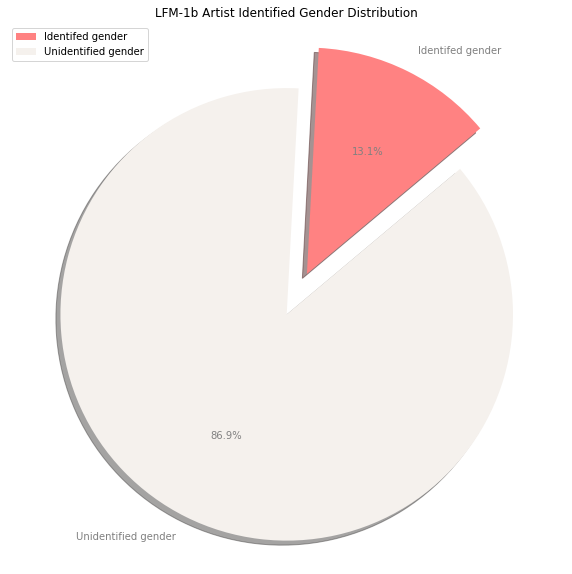

In [12]:
# Pie chart to display succesfully identified artists
labels = 'Identifed gender', 'Unidentified gender'
sizes = [total_count - undef_count, undef_count]

fig1, ax1 = plt.subplots(figsize=(10, 10))
explode = (0.2, 0) 
colors = ['#FF8282','#F5F1ED']

patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels=labels, colors = colors, autopct='%1.1f%%',
        shadow=True, startangle=40)

plt.legend(patches, labels, loc="best")

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')

plt.rcParams["figure.figsize"] = (2,2)
plt.title('LFM-1b Artist Identified Gender Distribution')
plt.show()

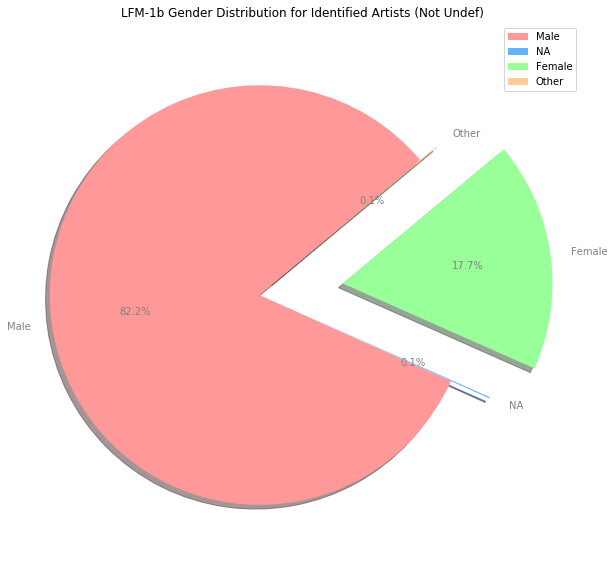

In [13]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

labels = 'Male', 'NA', 'Female', 'Other' 
sizes = [male_count, na_count, female_count, other_count]

fig1, ax1 = plt.subplots(figsize=(10, 10))

explode = (0, 0.2, 0.4, 0.1) 
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ffcc91']

patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels=labels, colors = colors, autopct='%1.1f%%',
        shadow=True, startangle=40)

plt.legend(patches, labels, loc="best")

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')

plt.rcParams["figure.figsize"] = (2,2)
plt.title('LFM-1b Gender Distribution for Identified Artists (Not Undef)')

plt.show()

### 3.2. Gender Analysis For Users in The LFM-1b dataset


In [14]:
user_df = pd.read_csv(user_file, sep='\t')
# print user data-frame
user_df.head()

,user_id,country,age,gender,playcount,registered_unixtime
0,384,UK,35,m,42139,1035849600
1,1206,NaN,-1,n,33103,1035849600
2,2622,NaN,-1,NaN,2030,1037404800
3,2732,NaN,-1,n,147,1037577600
4,3653,UK,31,m,18504,1041033600


In [15]:
# classify all users with nan as n/a, there is no provided gender information by the user and they therefore fall 
# under this class.
user_df.loc[user_df.gender.isnull(), 'gender'] = 'n'

In [16]:
# User gender distribution analysis
def compute_user_gender_dist(df_u):
    user_m = df_u[df_u.gender == 'm']
    user_f = df_u[df_u.gender == 'f']
    user_u = df_u[df_u.gender == 'n']
    return user_m, user_f, user_u

In [17]:
user_m, user_f, user_u = compute_user_gender_dist(user_df)
user_m_count = len(user_m)
user_f_count = len(user_f)
user_undef_count = len(user_u)
user_total_count = user_m_count + user_f_count + user_undef_count

# Output user gender distribution
print('User Gender Distribution in Matrix:')
print('m count: {}, {}%'.format(user_m_count,user_m_count*100/user_total_count))
print('f count: {}, {}%'.format(user_f_count,user_f_count*100/user_total_count))
print('u count: {}, {}%'.format(user_undef_count,user_undef_count*100/user_total_count))

User Gender Distribution in Matrix:
m count: 39969, 33.21836405644853%
f count: 15802, 13.133092867472282%
u count: 64551, 53.648543076079186%


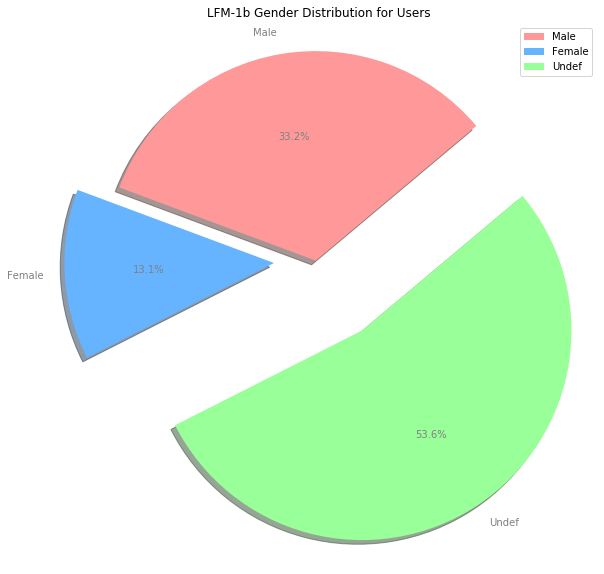

In [18]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Male', 'Female', 'Undef'
sizes = [user_m_count, user_f_count, user_undef_count]

fig1, ax1 = plt.subplots(figsize=(10, 10))

explode = (0, 0.2, 0.4) 
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

patches, texts, autotexts = ax1.pie(sizes, explode = explode, labels=labels, colors = colors, autopct='%1.1f%%',
        shadow=True, startangle=40)

plt.legend(patches, labels, loc="best")

ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

for text in texts:
    text.set_color('grey')
for autotext in autotexts:
    autotext.set_color('grey')

plt.rcParams["figure.figsize"] = (2,2)
plt.title('LFM-1b Gender Distribution for Users')

plt.show()

## 4. Gender Analysis with the user artist matrix .mat file

We now compute some stats for gender distribution with the user artist matrix provided in the LFM-1b dataset which will be used when generating user artist recommendations. 

In [19]:
# Read the user-artist-matrix and corresponding artist and user indices from Matlab file
mf = h5py.File(UAM_MATLAB_FILE, 'r')
user_ids = np.array(mf.get('idx_users')).astype(np.int64)
artist_ids = np.array(mf.get('idx_artists')).astype(np.int64)

# Load UAM
UAM = sparse.csr_matrix((mf['/LEs/']["data"],
                            mf['/LEs/']["ir"],
                            mf['/LEs/']["jc"])).transpose()  # .tocoo().transpose()

# user and artist indices to access UAM
UAM_user_idx = UAM.indices   # UAM.row -> for COO matrix
UAM_artist_idx = UAM.indptr  # UAM.col -> for COO matrix, i.e. pass artist id 5, tells you which col to look in

In [20]:
user_ids_flat = user_ids.flatten()
user_mat_df = user_df[user_df.user_id.isin(user_ids_flat)]
user_mat_df.head()

,user_id,country,age,gender,playcount,registered_unixtime
0,384,UK,35,m,42139,1035849600
1,1206,NaN,-1,n,33103,1035849600
2,2622,NaN,-1,n,2030,1037404800
3,2732,NaN,-1,n,147,1037577600
4,3653,UK,31,m,18504,1041033600


In [21]:
# convert all NaN gender to be N/A
user_mat_df.loc[user_mat_df.gender.isnull(), 'gender'] = 'n'

/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [22]:
# Gender distribution analysis of users in the matrix.
user_m, user_f, user_u = compute_user_gender_dist(user_mat_df)

user_m_count = len(user_m)
user_f_count = len(user_f)
user_undef_count = len(user_u)
user_total_count = user_m_count + user_f_count + user_undef_count

# Output user gender distribution
print('User Gender Distribution in Matrix:')
print('m count: {}, {}%'.format(user_m_count,user_m_count*100/user_total_count))
print('f count: {}, {}%'.format(user_f_count,user_f_count*100/user_total_count))
print('u count: {}, {}%'.format(user_undef_count,user_undef_count*100/user_total_count))

User Gender Distribution in Matrix:
m count: 39931, 33.22737674225088%
f count: 15781, 13.131682962346577%
u count: 64463, 53.64094029540254%


**Observations:**
As state in the paper, there are minimal chages with respect to user gender distributions in the matrix. The real change will come when observing the change in artist gender distribution next. 

In [23]:
artist_ids_flat = artist_ids.flatten()
artist_mat_df = artist_gender[artist_gender.id.isin(artist_ids_flat)]

# merge N/A class to become other class
artist_mat_df.loc[artist_mat_df['identified_gender'] == 4, 'identified_gender'] = 3

artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_df)

artist_m_count = len(artist_m)
artist_f_count = len(artist_f)
artist_undef_count = len(artist_u)
artist_other_count = len(artist_o)
artist_total_count = artist_m_count + artist_f_count + artist_undef_count + artist_other_count 

# Output artist gender distribution
print('Artist Gender Distribution in Matrix')
print('m count: {}, {}%'.format(artist_m_count,artist_m_count*100/artist_total_count))
print('f count: {}, {}%'.format(artist_f_count,artist_f_count*100/artist_total_count))
print('u count: {}, {}%'.format(artist_undef_count,artist_undef_count*100/artist_total_count))
print('o count: {}, {}%'.format(artist_other_count,artist_other_count*100/artist_total_count))

Artist Gender Distribution in Matrix
m count: 126823, 21.90845378206424%
f count: 27288, 4.713954777958012%
u count: 424519, 73.33492261741269%
o count: 247, 0.04266882256506995%


**Observations:** We can now see that we are able to identify around 27% of genders in the matrix.

## 5. LFM-1b-Le75 Gender Analysis: Users With Le history which consists of >= 75% of artists with known gender

From this matrix we compute ```LFM-1b-Le75.csv```, a csv file containing all user artist listening events for users which have a listening history for which over 75% have known gender. The code for this computation is left out of this notebook due to computational limits.

In [24]:
# read user events (with over 75% gender) into df
cols = ['user', 'artist', 'playcount']
df_events = pd.read_csv(lfm1b_le75_path, names=cols)
df_events.head()

,user,artist,playcount
0,384,18,3.0
1,384,30,153.0
2,384,43,7.0
3,384,47,518.0
4,384,48,5.0


In [25]:
print('max play count:', df_events.playcount.max())
print('min play count:', df_events.playcount.min())
print('average play count', df_events.playcount.mean())
print('std play count', df_events.playcount.std())

max play count: 247612.0
min play count: 1.0
average play count 17.962217076773506
std play count 120.80715157388336


In [26]:
print('total user-artist interactions:', len(df_events))
print('number of artists > 100:', len(df_events[df_events.playcount > 10000]) /  len(df_events))

total user-artist interactions: 48323180
number of artists > 100: 9.312301053035003e-06


We observe that there a very small number of users which have a high number of listening events > 10000. To compute what may define a recommendation as relevent (i.e. what play count can be considered as a relevent recommendation in evaluations) we first remove outliers in the data by computing the IQR.

In [27]:
df_events_ordered = df_events.sort_values(by=['playcount'], ascending=False)
df_events_ordered 

,user,artist,playcount
34852999,34995303,105,247612.0
16559032,9945174,2821,176993.0
21412572,14147992,8187,164685.0
8788388,5519723,3445,144035.0
29897084,26613726,691,120947.0
...,...,...,...
16163463,9690768,164540,1.0
32675783,31503402,65678,1.0
32675782,31503402,65668,1.0
16163464,9690768,164543,1.0


In [28]:
Q1 = df_events.playcount.quantile(0.25)
Q3 = df_events.playcount.quantile(0.75)
IQR = Q3 - Q1
print('Quartile 1 playcounts:', Q1)
print('Quartile 2 playcounts:', Q3)
print('IQR playcounts:', IQR)

Quartile 1 playcounts: 1.0
Quartile 2 playcounts: 9.0
IQR playcounts: 8.0


In [29]:
filter_outliers = df_events[((df_events.playcount < (Q1 - 1.5 * IQR)) == False) & ((df_events.playcount > (Q3 + 1.5 * IQR)) == False)]

In [30]:
print('before filtering df length:', len(df_events))
print('after filtering df length:', len(filter_outliers))

before filtering df length: 48323180
after filtering df length: 41751302


In [31]:
print('max play count:', filter_outliers.playcount.max())
print('min play count:', filter_outliers.playcount.min())
print('average play count', filter_outliers.playcount.mean())
print('std play count', filter_outliers.playcount.std())

max play count: 21.0
min play count: 1.0
average play count 3.9231675697203405
std play count 4.462467186803458


We now see that the average playcount drops dramatically to aproximately 4. Hence, we consider playcounts >= 4 as the relevent when evaluating filtering methodologies. 

In [32]:
import math
# we will use a logarthmic scale of listening counts to symbolise that listening events >= 70 will be 'relevent' 
math.log(4,1.02)

70.005577562293

### User gender distribution analysis

In [33]:
# Gender distribution analysis of users in the le75 matrix.
user_ids_knownlh = df_events['user'].unique()  #get all unique user ids from LFM-1b-Le75
user_mat_le75_df = user_mat_df[user_mat_df.user_id.isin(user_ids_knownlh)]
user_m, user_f, user_u = compute_user_gender_dist(user_mat_le75_df)

user_m_count = len(user_m)
user_f_count = len(user_f)
user_undef_count = len(user_u)
user_total_count = user_m_count + user_f_count + user_undef_count

print('User Gender Distribution in LFM-1b-Le75 Matrix:')
print('m count: {}, {}%'.format(user_m_count,user_m_count*100/user_total_count))
print('f count: {}, {}%'.format(user_f_count,user_f_count*100/user_total_count))
print('u count: {}, {}%'.format(user_undef_count,user_undef_count*100/user_total_count))

User Gender Distribution in LFM-1b-Le75 Matrix:
m count: 31443, 39.462586912322095%
f count: 11520, 14.458194231782926%
u count: 36715, 46.07921885589498%


### Artist gender distribution analysis

In [34]:
# Gender distribution anlaysis of artists in the le75 matrix
artist_ids_flat = df_events['artist'].unique()
artist_mat_le75_df = artist_gender[artist_gender.id.isin(artist_ids_flat)]

# merge na class to become other class
artist_mat_le75_df.loc[artist_mat_le75_df['identified_gender'] == 4, 'identified_gender'] = 3

artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df)

artist_m_count = len(artist_m)
artist_f_count = len(artist_f)
artist_undef_count = len(artist_u)
artist_other_count = len(artist_o)
artist_total_count = artist_m_count + artist_f_count + artist_undef_count + artist_other_count 

# Output artist gender distribution
print('Artist Gender Distribution in Matrix')
print('m count: {}, {}%'.format(artist_m_count,artist_m_count*100/artist_total_count))
print('f count: {}, {}%'.format(artist_f_count,artist_f_count*100/artist_total_count))
print('u count: {}, {}%'.format(artist_undef_count,artist_undef_count*100/artist_total_count))
print('o count: {}, {}%'.format(artist_other_count,artist_other_count*100/artist_total_count))

Artist Gender Distribution in Matrix
m count: 126781, 21.906837063352732%
f count: 27273, 4.712576547186243%
u count: 424427, 73.33790658133009%
o count: 247, 0.04267980813093543%


### Recover Listening Events via manual annotation of undef artists...
We were additionally able to recover over 30 million listening events via manual annotation of the top 100 undef artists based on listening counts. These are then updated in the artist_mat dataframe before running CF recommendations.

In [35]:
import ast

top100_undef_artists = 'baseline-data/top500undef_lp.csv' #todo change path
top100undef_artist_df = pd.read_csv(top100_undef_artists, sep=',')
undef_gender_dist_list = top100undef_artist_df['gender_dist'].map(ast.literal_eval)

top100undef_artist_df = top100undef_artist_df.assign(gender_dist = undef_gender_dist_list)

# classify gender
top100undef_majority_gender = undef_gender_dist_list.map(classify_gender_majority)
# reasign the data frame
top100undef_artist_df = top100undef_artist_df.assign(identified_gender = top100undef_majority_gender)

top100user_list = list(top100undef_artist_df['artist'])
top100user_gender_list = list(top100undef_artist_df['identified_gender'])
top100user_genderdist_list = list(top100undef_artist_df['gender_dist'])

# 135 as test id
for u, g, g_dist in zip(top100user_list, top100user_gender_list, top100user_genderdist_list):
    artist_mat_le75_df.loc[(artist_mat_le75_df.id == u),'identified_gender'] = g
    artist_mat_le75_df.loc[(artist_mat_le75_df.id == u),'gender_dist'] = str(g_dist)

# print Nivarna as an example to test we have correctly updated the df    
artist_mat_le75_df[artist_mat_le75_df.id == 135]

,id,artist,gender_dist,identified_gender
134,135,Nirvana,"[0, 3, 0, 0, 0]",1


In [36]:
# Analyse our gender dists after updating the manual annotations in the df
artist_ids_flat = df_events['artist'].unique()

# Gender distribution analysis
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df)

artist_m_count = len(artist_m)
artist_f_count = len(artist_f)
artist_undef_count = len(artist_u)
artist_other_count = len(artist_o)
artist_total_count = artist_m_count + artist_f_count + artist_undef_count + artist_other_count 

# Output artist gender distribution
print('Artist Gender Distribution in Matrix')
print('m count: {}, {}%'.format(artist_m_count,artist_m_count*100/artist_total_count))
print('f count: {}, {}%'.format(artist_f_count,artist_f_count*100/artist_total_count))
print('u count: {}, {}%'.format(artist_undef_count,artist_undef_count*100/artist_total_count))
print('o count: {}, {}%'.format(artist_other_count,artist_other_count*100/artist_total_count))

Artist Gender Distribution in Matrix
m count: 126864, 21.92117886122669%
f count: 27280, 4.713786096404529%
u count: 424337, 73.32235523423785%
o count: 247, 0.04267980813093543%


In [37]:
# filter to just contain user of m and f gender and artists of m and f gender
m_user_ids_sample = user_m['user_id'].values
f_user_ids_sample = user_f['user_id'].values
users_mf = [y for x in [m_user_ids_sample, f_user_ids_sample] for y in x] #male and female users

male_artist_ids = artist_m['id'].unique()
female_artist_ids = artist_f['id'].unique()
artist_sample = [y for x in [male_artist_ids, female_artist_ids] for y in x]
final_le_df = df_events[(df_events.user.isin(users_mf) & (df_events.artist.isin(artist_sample)))]

In [38]:
# Analyse our gender dists after updating the manual annotations in the df
artist_mat_le75_df_update = artist_mat_le75_df[artist_mat_le75_df.id.isin(final_le_df.artist.unique())]
user_mat_le75_df_update = user_mat_le75_df[user_mat_le75_df.user_id.isin(final_le_df.user.unique())]

# Gender distribution analysis
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(artist_mat_le75_df_update)
user_m, user_f, user_u = compute_user_gender_dist(user_mat_le75_df_update)

In [39]:
user_ids = final_le_df.user.unique()

In [40]:
f_pref = []
m_pref = []

for u in user_ids:
    df = final_le_df[final_le_df.user == u]
    item_len = len(df)
    f_items = df[df.artist.isin(list(artist_f.id))]
    f_pref_u = len(f_items) / item_len
    m_pref_u = 1 - f_pref_u
    f_pref.append(f_pref_u)
    m_pref.append(m_pref_u)

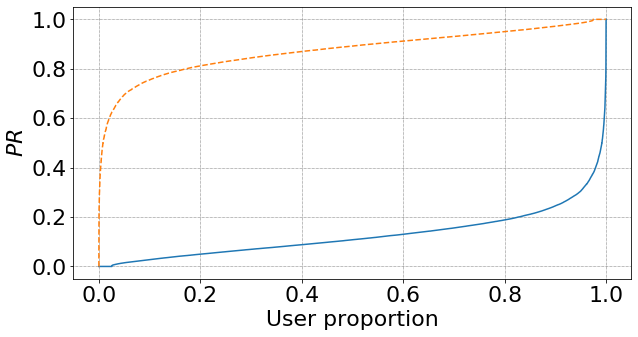

In [41]:
## Plot the distribution of user input preferences in the data

%matplotlib inline
plt.rcParams.update({'font.size': 22})

plt.rcParams["figure.figsize"] = [10, 5]
x = np.arange(1,len(user_ids)+1)
x = [i/len(user_ids) for i in x]
plt.figure()
plt.xlabel('User proportion')
plt.ylabel('$PR$')
plt.plot(x, sorted(f_pref), label='Female artist pref ratio')
plt.plot(x, sorted(m_pref), linestyle='dashed', label='Male artist pref ratio')
plt.grid(linestyle=':', linewidth='0.5', color='black')

In [42]:
user_dimension = len(final_le_df.user.unique())
artist_dimension = len(final_le_df.artist.unique())
print('Dimentionality of final matrix: {} - {}'.format(user_dimension, artist_dimension) )

Dimentionality of final matrix: 42961 - 152806


### Write both user and artist dfs to csv files to be used in subsequent experiments

In [44]:
final_le_df.to_csv(lfm1b_le75_filtered_mf_path, index = False)

In [45]:
# write our updated user and artist matrix to csv files to be used in subsequent experiments
artist_mat_le75_df.to_csv(lfm1b_le75_artists_path, index = False)
user_mat_le75_df.to_csv(lfm1b_le75_users_path, index = False)

### Analysis of of gender distributions in the longtail

In [46]:
# Compute artists which are in the longtail
artist_unique_users = final_le_df['artist'].value_counts()
artist_playcounts = final_le_df[['artist','playcount']].groupby(['artist']).mean()
combined_df = pd.concat([artist_unique_users , artist_playcounts], axis=1)
    
combined_df.columns = ['user_count', 'avg_playcount']
combined_df['popularity'] = combined_df['user_count']*combined_df['avg_playcount']
combined_df = combined_df.sort_values(by=['popularity'])
artists = combined_df.index.values.tolist()
slice_i = int(len(artists) * 0.8) #consider 80% as the longtail
lt_artists = artists[:slice_i]
th_artists = artists[slice_i:]

In [47]:
th_artists_df = artist_mat_le75_df[artist_mat_le75_df.id.isin(th_artists)]
th_artist_u, th_artist_m, th_artist_f, th_artist_o, th_artist_na = compute_artist_gender_dist(th_artists_df)
#th_artist_f
total_a = len(th_artist_m) + len(th_artist_f)
print('male top head artists {} / {}%'.format(len(th_artist_m),(len(th_artist_m)*100)/total_a))
print('female top head artists {} / {}%'.format(len(th_artist_f),(len(th_artist_f)*100)/total_a))

male top head artists 25735 / 84.20587657875794%
female top head artists 4827 / 15.794123421242066%


In [48]:
longt_artists = artist_mat_le75_df[artist_mat_le75_df.id.isin(lt_artists)]
lt_artist_u, lt_artist_m, lt_artist_f, lt_artist_o, lt_artist_na = compute_artist_gender_dist(longt_artists)
total_a = len(lt_artist_m) + len(lt_artist_f)

print('male long tail artists {} / {}%'.format(len(lt_artist_m),(len(lt_artist_m)*100)/total_a))
print('female long tail artists {} / {}%'.format(len(lt_artist_f),(len(lt_artist_f)*100)/total_a))

male long tail artists 100083 / 81.87150289584766%
female long tail artists 22161 / 18.128497104152352%


### Analaysis of gender distribution of most popular artists

In [49]:
most_popular_artists_df = df_events[['artist','playcount']].groupby('artist').sum()

In [50]:
most_popular_artists_df = most_popular_artists_df.sort_values(by=['playcount'], ascending=False)
top100_artist_ids = most_popular_artists_df.index[:1000]

In [51]:
most_popular_artists_df['artist'] = most_popular_artists_df.index

In [52]:
top100_artists = artist_mat_le75_df[artist_mat_le75_df.id.isin(top100_artist_ids)]

In [53]:
# Gender distribution analysis
artist_u, artist_m, artist_f, artist_o, artist_na = compute_artist_gender_dist(top100_artists)

artist_m_count = len(artist_m)
artist_f_count = len(artist_f)
artist_undef_count = len(artist_u)
artist_other_count = len(artist_o)
artist_total_count = artist_m_count + artist_f_count + artist_undef_count + artist_other_count 

# Output artist gender distribution
print('Artist Gender Distribution in Matrix')
print('m count: {}, {}%'.format(artist_m_count,artist_m_count*100/artist_total_count))
print('f count: {}, {}%'.format(artist_f_count,artist_f_count*100/artist_total_count))
print('u count: {}, {}%'.format(artist_undef_count,artist_undef_count*100/artist_total_count))
print('o count: {}, {}%'.format(artist_other_count,artist_other_count*100/artist_total_count))

Artist Gender Distribution in Matrix
m count: 811, 85.099685204617%
f count: 78, 8.184679958027282%
u count: 61, 6.40083945435467%
o count: 3, 0.3147953830010493%


In [54]:
for id_a in artist_m.id.values:
    pc = most_popular_artists_df[most_popular_artists_df.artist == id_a].playcount.values[0]
    artist_m.loc[artist_m['id'] == id_a, 'playcount'] = pc

artist_m.sort_values(by=['playcount'], ascending=False)[:10]

/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/dshakes/enviroments/thesis/env/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,artist,gender_dist,identified_gender,playcount
1601,1602,Radiohead,"[0, 5, 0, 0, 0]",1,2583521.0
367,368,The Beatles,"[0, 6, 0, 0, 0]",1,2470811.0
53,54,Pink Floyd,"[0, 6, 0, 0, 0]",1,2094891.0
319,320,Daft Punk,"[0, 2, 0, 0, 0]",1,2047174.0
54,55,Metallica,"[0, 8, 0, 0, 0]",1,1894880.0
300,301,Linkin Park,"[2, 7, 0, 0, 0]",1,1878695.0
152,153,Muse,"[0, 3, 0, 0, 0]",1,1831174.0
45,46,Coldplay,"[0, 4, 0, 0, 0]",1,1775041.0
4114,4115,Arctic Monkeys,"[0, 5, 0, 0, 0]",1,1702441.0
26,27,Red Hot Chili Peppers,"[0, 18, 0, 0, 0]",1,1577816.0


In [55]:
for id_a in artist_f.id.values:
    pc = most_popular_artists_df[most_popular_artists_df.artist == id_a].playcount.values[0]
    artist_f.loc[artist_f['id'] == id_a, 'playcount'] = pc

artist_f.sort_values(by=['playcount'], ascending=False)[:10]

,id,artist,gender_dist,identified_gender,playcount
401,402,Lana Del Rey,"[0, 0, 1, 0, 0]",2,1220124.0
136,137,Lady Gaga,"[0, 0, 1, 0, 0]",2,1072581.0
354,355,Rihanna,"[0, 0, 1, 0, 0]",2,772051.0
4082,4083,Björk,"[0, 0, 1, 0, 0]",2,694054.0
349,350,Madonna,"[0, 0, 1, 0, 0]",2,599308.0
27,28,Avril Lavigne,"[0, 0, 1, 0, 0]",2,597773.0
352,353,Britney Spears,"[0, 0, 1, 0, 0]",2,583874.0
3731,3732,Katy Perry,"[0, 0, 1, 0, 0]",2,578455.0
9717,9718,Glee Cast,"[0, 8, 9, 0, 0]",2,559774.0
4090,4091,Ellie Goulding,"[0, 0, 1, 0, 0]",2,551881.0
